In [1]:
import networkx
import pandas
import numpy
import scipy
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
from random import sample
seaborn.set_style("whitegrid")

# Ramdom graph approach to clusterize cells

In [2]:
normalized_cell_data = pandas.read_csv("../data/filtered_normalized_expression_in_cells.csv", index_col=0)

In [3]:
gene_names = list(normalized_cell_data.keys())[3:]
all_cell_ids = normalized_cell_data.cell_id
total_cell_amount = len(all_cell_ids)

In [4]:
class Cell:
    def __init__(self, cell_id, x, y, gene_names, genes_expression):
        self.cell_id = cell_id
        self.x = x
        self.y = y
        self.gene_expression = {name: expr for name, expr in zip(gene_names, genes_expression) if expr > 0}


In [5]:
cells = dict()
for _, row in normalized_cell_data.iterrows():
    row = row.values
    cell_id = int(row[0])
    
    
    cells[cell_id] = Cell(
        cell_id=cell_id, 
        x=int(row[1]), 
        y=int(row[2]), 
        gene_names=gene_names, 
        genes_expression=row[3:]
    )
    

In [6]:
def euclidean_dist_between_cells(cell_1, cell_2):
    return numpy.sqrt((cell_1.x - cell_2.x)**2 + (cell_1.y - cell_2.y)**2)


In [8]:
expected_distance = 0
max_distance = 0
closest_neighbor_dists = [float("inf") for _ in range(total_cell_amount)]
min_distance = float("inf")
for i in tqdm.tqdm(range(total_cell_amount)):
    for j in range(i + 1, total_cell_amount):
        new_dist = euclidean_dist_between_cells(cells[all_cell_ids[i]], cells[all_cell_ids[j]])
        expected_distance += new_dist
        max_distance = max(max_distance, new_dist)
        closest_neighbor_dists[i] = min(closest_neighbor_dists[i], new_dist)
        closest_neighbor_dists[j] = min(closest_neighbor_dists[j], new_dist)
        min_distance = min(min_distance, new_dist)
expected_distance = expected_distance / (total_cell_amount * (total_cell_amount - 1)) * 2
expected_distance, min_distance, max_distance

  0%|          | 0/4872 [00:00<?, ?it/s]

(2135.875784555593, 7.615773105863909, 5663.216400597808)

In [9]:
mean_nearest_distance = numpy.mean(closest_neighbor_dists)
max_nearest_distance = numpy.max(closest_neighbor_dists)
mean_nearest_distance, max_nearest_distance

(23.285244567133955, 191.12822920751398)

In [10]:
def probability_distance(x, scale=max_nearest_distance):
    return 1 - scipy.stats.halfnorm.cdf(x, scale=scale)

def probability_shared_genes(genes_expression_left, gene_expression_right):
    shared = set(genes_expression_left).intersection(set(gene_expression_right))    
    return 2 * sum(
        1 - abs(
            genes_expression_left[name] - gene_expression_right[name]
        ) / (
            genes_expression_left[name] + gene_expression_right[name]
        ) for name in shared
    ) / (len(genes_expression_left) + len(gene_expression_right))

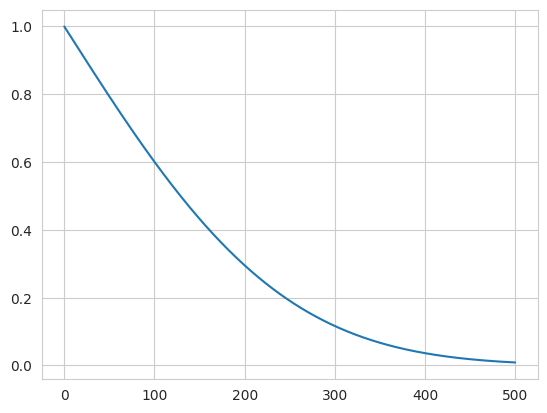

In [11]:
_x_test = numpy.linspace(0, 500, 1000)
seaborn.lineplot(x=_x_test, y=probability_distance(_x_test))
plt.show()

In [14]:
all_distance_probs = dict()
all_gene_expression_probs = dict()
for i in tqdm.tqdm(range(total_cell_amount)):
    for j in range(i + 1, total_cell_amount):
        all_gene_expression_probs[(i, j)] = probability_shared_genes(
            cells[all_cell_ids[i]].gene_expression, 
            cells[all_cell_ids[j]].gene_expression
        )
        all_distance_probs[(i, j)] = probability_distance(
            euclidean_dist_between_cells(
                cells[all_cell_ids[i]],
                cells[all_cell_ids[j]]
            )
        )


  0%|          | 0/4872 [00:00<?, ?it/s]

In [28]:
array_of_all_distance_probs = numpy.zeros((total_cell_amount, total_cell_amount))
array_of_all_gene_exp_probs = numpy.zeros((total_cell_amount, total_cell_amount))
for (i, j), prob in all_distance_probs.items():
    array_of_all_distance_probs[i][j] = prob
for (i, j), prob in all_gene_expression_probs.items():
    array_of_all_gene_exp_probs[i][j] = prob

In [32]:
with open("../data/dist_probs.npy", "wb") as f:
    numpy.save(f, array_of_all_distance_probs)
with open("../data/gene_probs.npy", "wb") as f:
    numpy.save(f, array_of_all_gene_exp_probs)

In [12]:
# with open("../data/dist_probs.npy", "rb") as f:
#     array_of_all_distance_probs = numpy.load(f)
# with open("../data/gene_probs.npy", "rb") as f:
#     array_of_all_gene_exp_probs = numpy.load(f)

In [13]:
numpy.mean(array_of_all_distance_probs), numpy.mean(array_of_all_gene_exp_probs)

(0.009694159964802662, 0.0472278884548133)

In [14]:
numpy.max(array_of_all_distance_probs), numpy.max(array_of_all_gene_exp_probs)

(0.9682155785881601, 1.0)

In [15]:
numpy.min(array_of_all_distance_probs), numpy.min(array_of_all_gene_exp_probs)

(0.0, 0.0)

In [16]:
edge_probability = 1 / 2 * (array_of_all_distance_probs + array_of_all_gene_exp_probs)
_edges_amount_expected = numpy.sum(edge_probability)

In [17]:
print(f"Estimated egge number is {_edges_amount_expected}")
print(f"Estimated vertex degree is {675561 / _edges_amount_expected}")

Estimated egge number is 675561.7996772947
Estimated vertex degree is 0.9999988162781036


In [18]:
random_cells_graph = networkx.Graph()

In [19]:
for i in tqdm.tqdm(range(total_cell_amount)):
    for j in range(i + 1, total_cell_amount):
        if numpy.random.random() < edge_probability[i][j]:
            random_cells_graph.add_edge(i, j)

  0%|          | 0/4872 [00:00<?, ?it/s]

In [66]:
len(random_cells_graph.edges)

675288

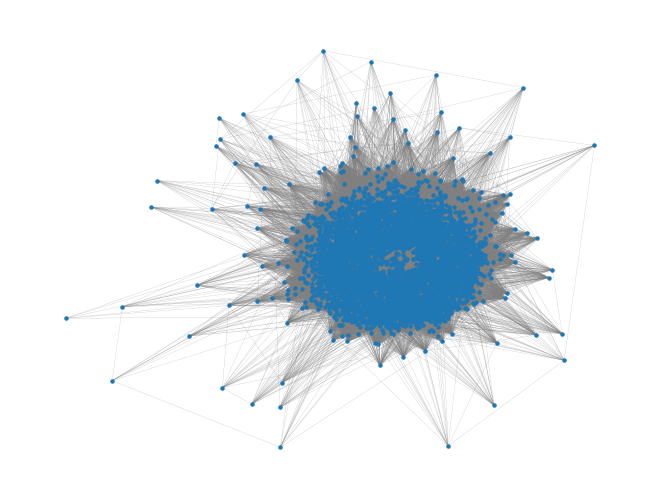

In [81]:
networkx.draw(random_cells_graph, node_size=5, edge_color="#808080", width=.1)

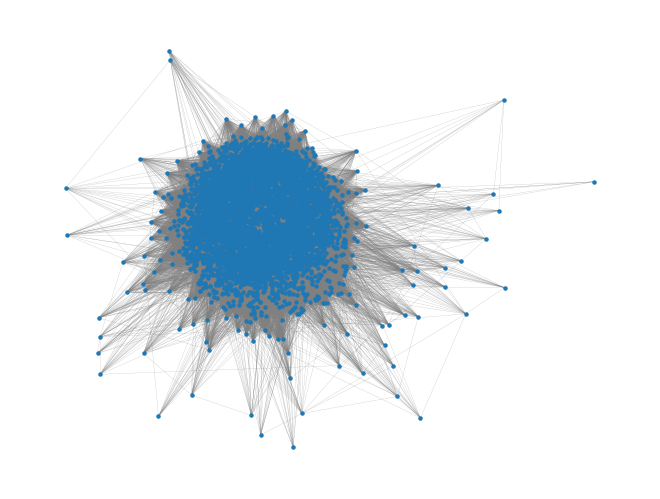

In [90]:
pos = networkx.fruchterman_reingold_layout(random_cells_graph)
networkx.draw(random_cells_graph, pos=pos, node_size=5, edge_color="#808080", width=.1)

In [77]:
poses = {idx: (cells[cell_id].x, cells[cell_id].y) for idx, cell_id in enumerate(all_cell_ids)}

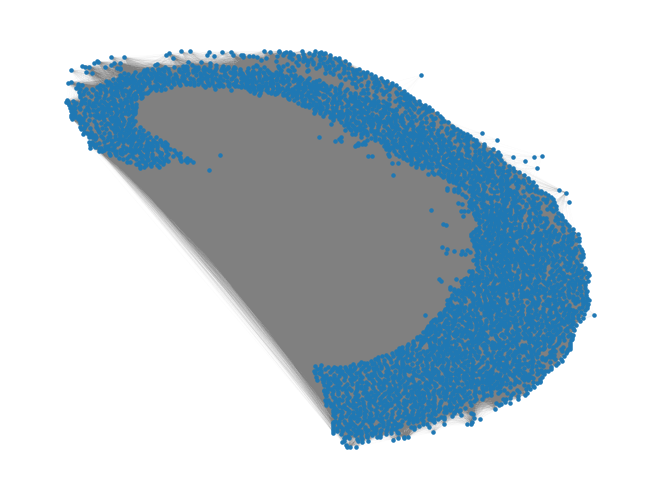

In [82]:
networkx.draw(random_cells_graph, node_size=5, pos=poses, edge_color="#808080", width=.01)

In [85]:
len(all_cell_ids) * (len(all_cell_ids) - 1) / 2

11865756.0

In [87]:
11865756 / len(random_cells_graph.edges)

17.571400646835126

In [70]:
dist_importance = 1.9
edge_probability_distance_important = 1 / 2 * (
    dist_importance * array_of_all_distance_probs + 
    (2 - dist_importance) * array_of_all_gene_exp_probs
)

In [71]:
numpy.sum(edge_probability_distance_important)

274650.05310151307

In [72]:
dist_important_random_cells_graph = networkx.Graph()
for i in tqdm.tqdm(range(total_cell_amount)):
    for j in range(i + 1, total_cell_amount):
        if numpy.random.random() < edge_probability_distance_important[i][j]:
            dist_important_random_cells_graph.add_edge(i, j)

  0%|          | 0/4872 [00:00<?, ?it/s]

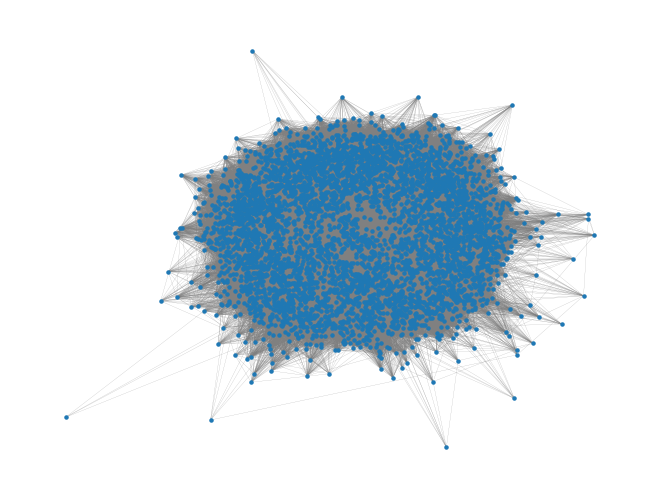

In [104]:
networkx.draw(dist_important_random_cells_graph, node_size=5, edge_color="#808080", width=.1)

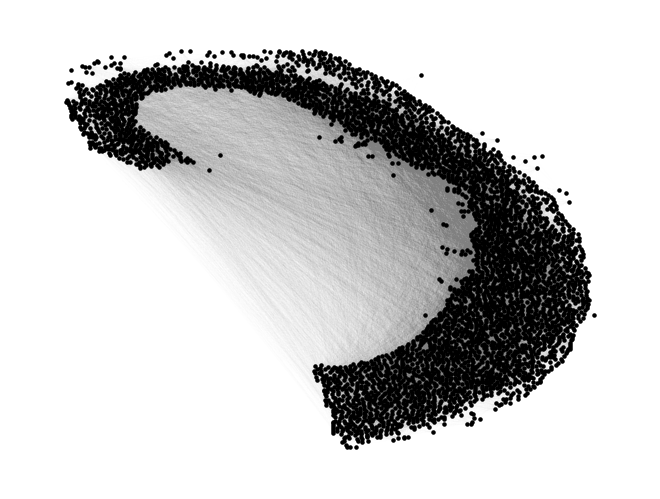

In [140]:
networkx.draw(
    dist_important_random_cells_graph, 
    node_size=5, 
    node_color="black", 
    pos=poses, 
    edge_color="#808080", 
    width=.001
)

In [73]:
# select_subgraph

vertex_subset = []
for i in tqdm.tqdm(range(total_cell_amount)):
    x, y = cells[all_cell_ids[i]].x, cells[all_cell_ids[i]].y
    if x > 19000 and x < 20600 and y > 8000 and y < 11000:
        vertex_subset.append(i)

dist_important_random_cells_graph_subgraph = dist_important_random_cells_graph.subgraph(vertex_subset)


  0%|          | 0/4872 [00:00<?, ?it/s]

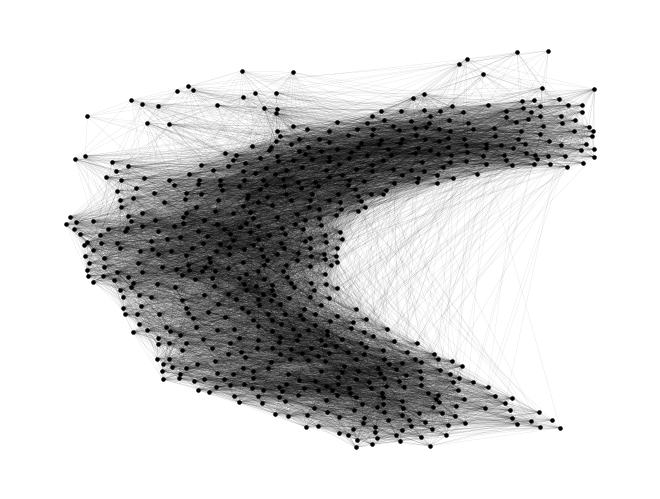

In [148]:
networkx.draw(
    dist_important_random_cells_graph_subgraph, 
    node_size=5, 
    node_color="black", 
    pos=poses, 
#     edge_color="#808080", 
    width=.03
)

In [106]:
len(dist_important_random_cells_graph.edges)

275320

In [107]:
edge_probability_sparsed = 1 / 10 * (array_of_all_distance_probs + array_of_all_gene_exp_probs)

In [108]:
sparsed_random_cells_graph = networkx.Graph()
for i in tqdm.tqdm(range(total_cell_amount)):
    for j in range(i + 1, total_cell_amount):
        if numpy.random.random() < edge_probability_sparsed[i][j]:
            sparsed_random_cells_graph.add_edge(i, j)

  0%|          | 0/4872 [00:00<?, ?it/s]

In [109]:
len(sparsed_random_cells_graph.edges)

134767

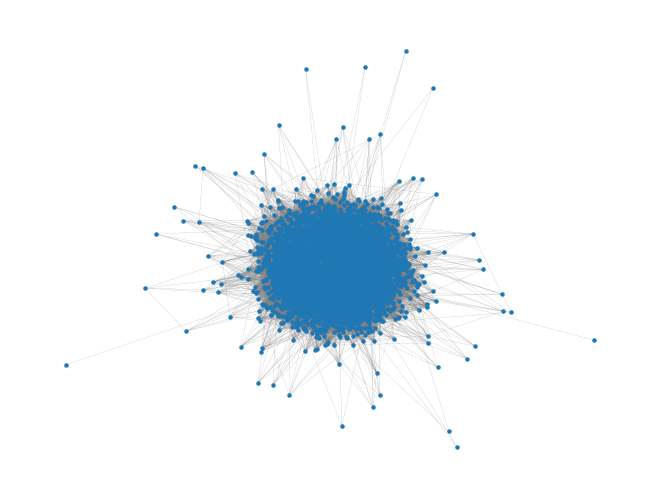

In [110]:
networkx.draw(sparsed_random_cells_graph, node_size=5, edge_color="#808080", width=.1)

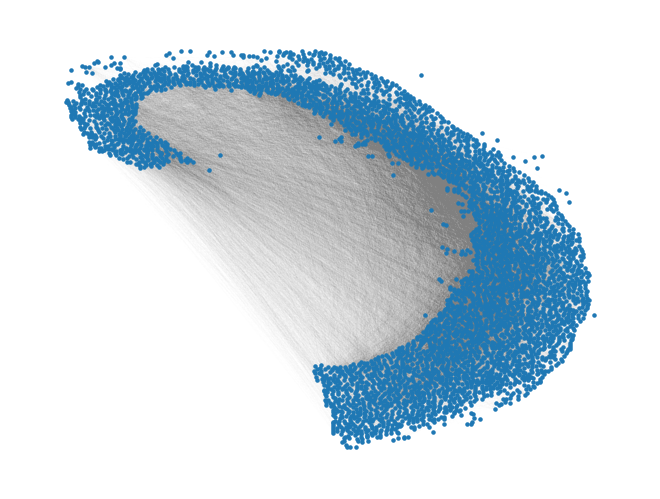

In [121]:
networkx.draw(sparsed_random_cells_graph, node_size=5, pos=poses, edge_color="#808080", width=.0005)

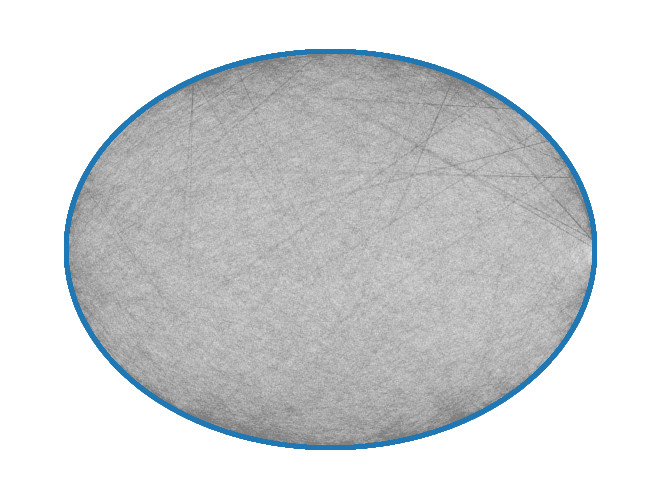

In [118]:
pos = networkx.circular_layout(sparsed_random_cells_graph)
networkx.draw(sparsed_random_cells_graph, pos=pos, node_size=5, edge_color="#808080", width=.0005)

In [122]:
edge_probability_very_sparsed = 1 / 100 * (array_of_all_distance_probs + array_of_all_gene_exp_probs)

In [123]:
very_sparsed_random_cells_graph = networkx.Graph()
for i in tqdm.tqdm(range(total_cell_amount)):
    for j in range(i + 1, total_cell_amount):
        if numpy.random.random() < edge_probability_very_sparsed[i][j]:
            very_sparsed_random_cells_graph.add_edge(i, j)

  0%|          | 0/4872 [00:00<?, ?it/s]

In [124]:
len(very_sparsed_random_cells_graph.edges)

13402

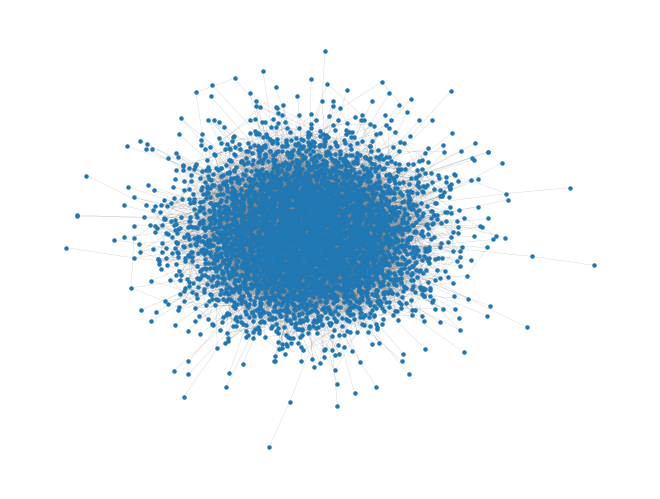

In [125]:
networkx.draw(very_sparsed_random_cells_graph, node_size=5, edge_color="#808080", width=.1)

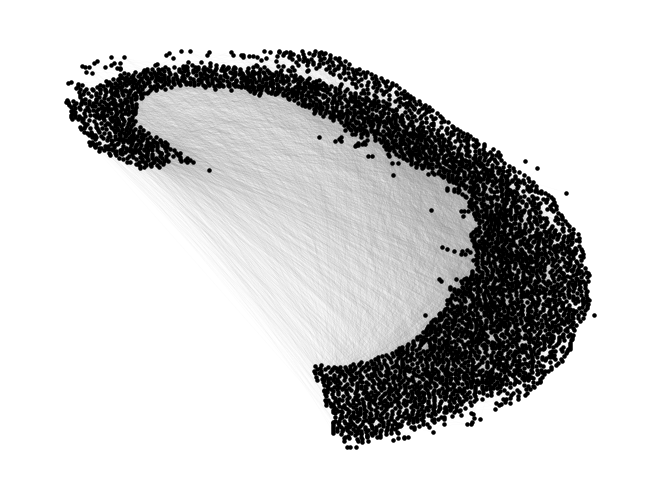

In [139]:
networkx.draw(
    very_sparsed_random_cells_graph, 
    node_size=5, 
    pos=poses, 
    edge_color="#808080", 
    width=.01,
    node_color="black", 
)

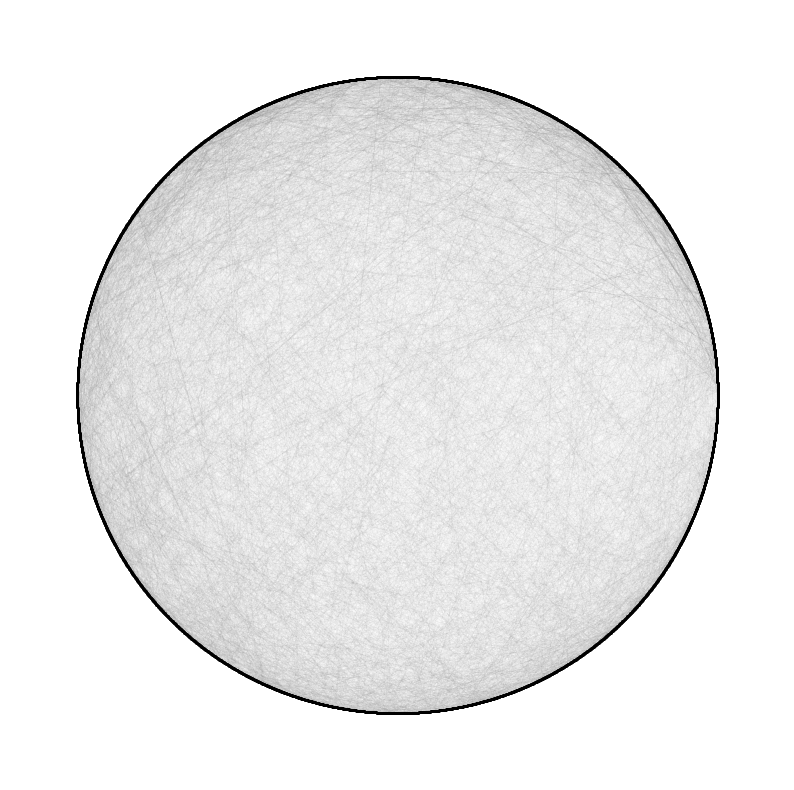

In [137]:
pos = networkx.circular_layout(very_sparsed_random_cells_graph)
fig, ax = plt.subplots(figsize=(10, 10))
networkx.draw(
    very_sparsed_random_cells_graph, 
    pos=pos, 
    node_size=1, 
    edge_color="#808080", 
    node_color="black", 
    width=.01, 
    ax=ax
)

In [151]:
# borders_visualization
x_min, x_max = min(cell.x for cell in cells.values()), max(cell.x for cell in cells.values())
y_min, y_max = min(cell.y for cell in cells.values()), max(cell.y for cell in cells.values())

In [152]:
x_min, x_max, y_min, y_max, (x_max - x_min) * (y_max - y_min)

(19875, 22695, 4477, 10074, 15783540)

In [173]:
numpy.random.seed(42)
frame = 1000
window = 100
vertex_degree_matrix = numpy.zeros((x_max - x_min + frame, y_max - y_min + frame))
for idx, cell_id in tqdm.tqdm(list(enumerate(all_cell_ids))):
    _x, _y = cells[cell_id].x - x_max - frame // 2, cells[cell_id].y - y_max - frame // 2
    for i in range(window):
        for j in range(window):
            vertex_degree_matrix[_x - window // 2 + i][_y - window // 2 + j] += random_cells_graph.degree(idx)


  0%|          | 0/4872 [00:00<?, ?it/s]

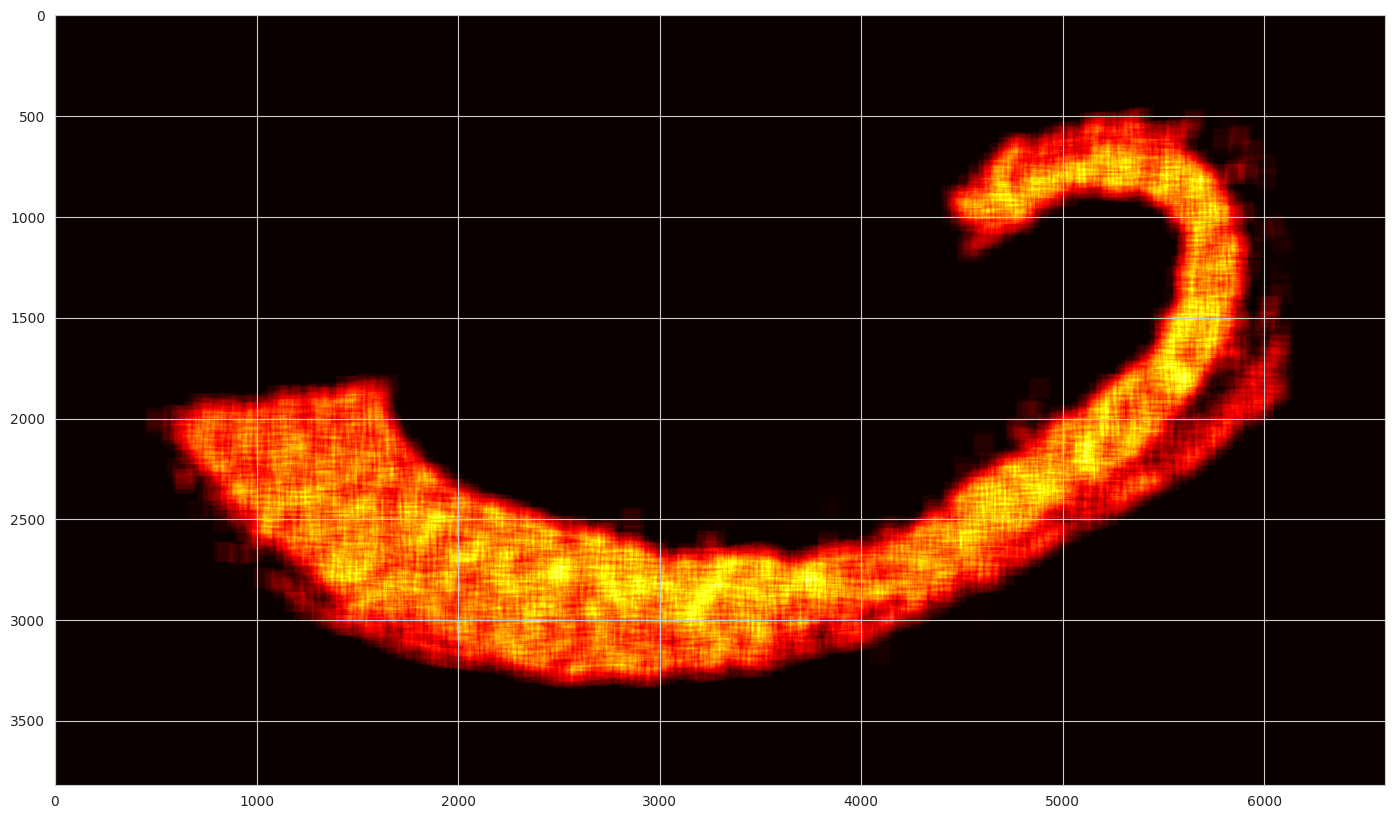

In [174]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(vertex_degree_matrix, cmap='hot')
plt.show()

/tmp/ipykernel_2498008/3162138997.py:2: RuntimeWarning: divide by zero encountered in log
  ax.imshow(numpy.log(vertex_degree_matrix), cmap='hot')


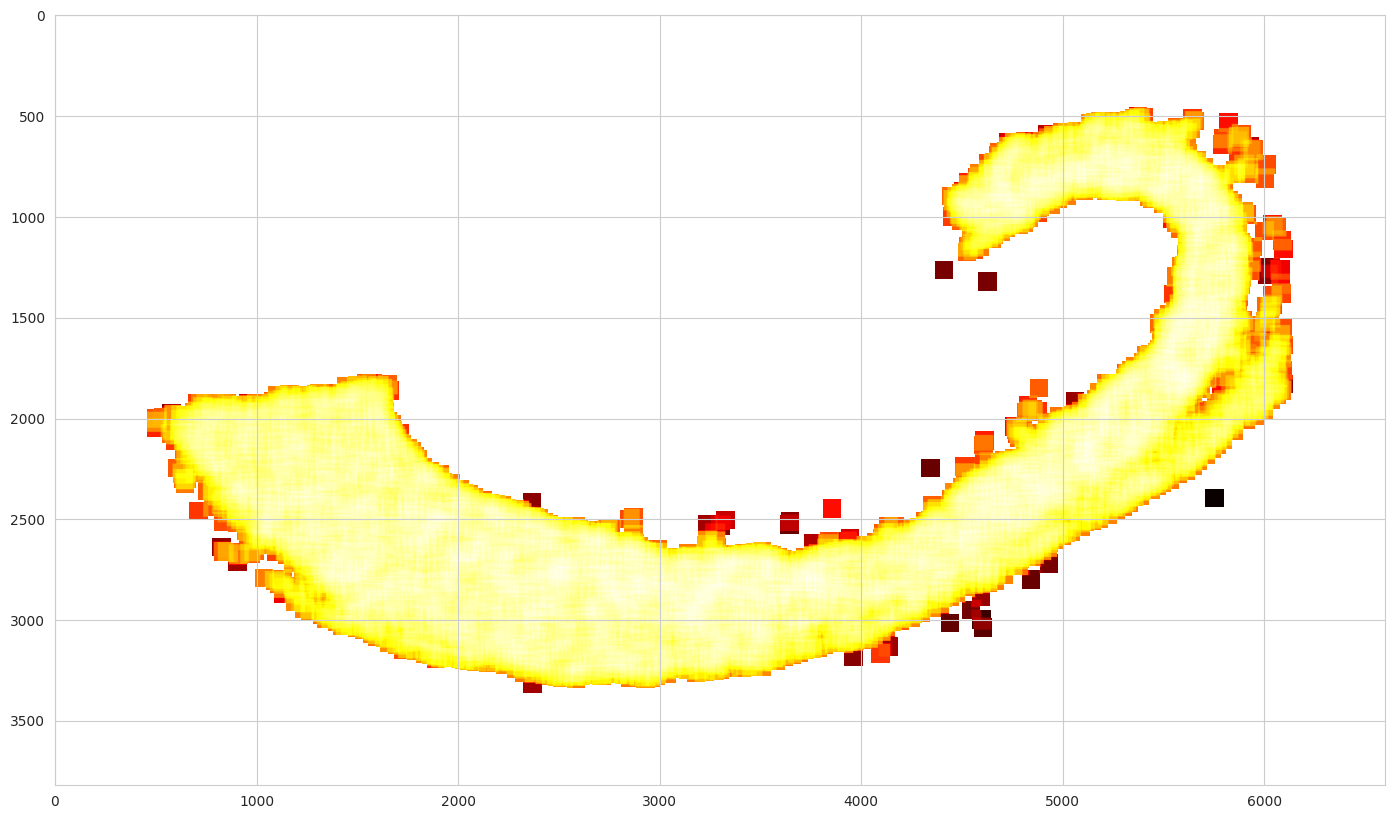

In [175]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(numpy.log(vertex_degree_matrix), cmap='hot')
plt.show()


In [176]:
numpy.random.seed(42)
frame = 1000
window = 50
sparsed_vertex_degree_matrix = numpy.zeros((x_max - x_min + frame, y_max - y_min + frame))
for idx, cell_id in tqdm.tqdm(list(enumerate(all_cell_ids))):
    _x, _y = cells[cell_id].x - x_max - frame // 2, cells[cell_id].y - y_max - frame // 2
    for i in range(window):
        for j in range(window):
            new_x = _x - window // 2 + i
            new_y = _y - window // 2 + j
            sparsed_vertex_degree_matrix[new_x][new_y] += sparsed_random_cells_graph.degree(idx)


  0%|          | 0/4872 [00:00<?, ?it/s]

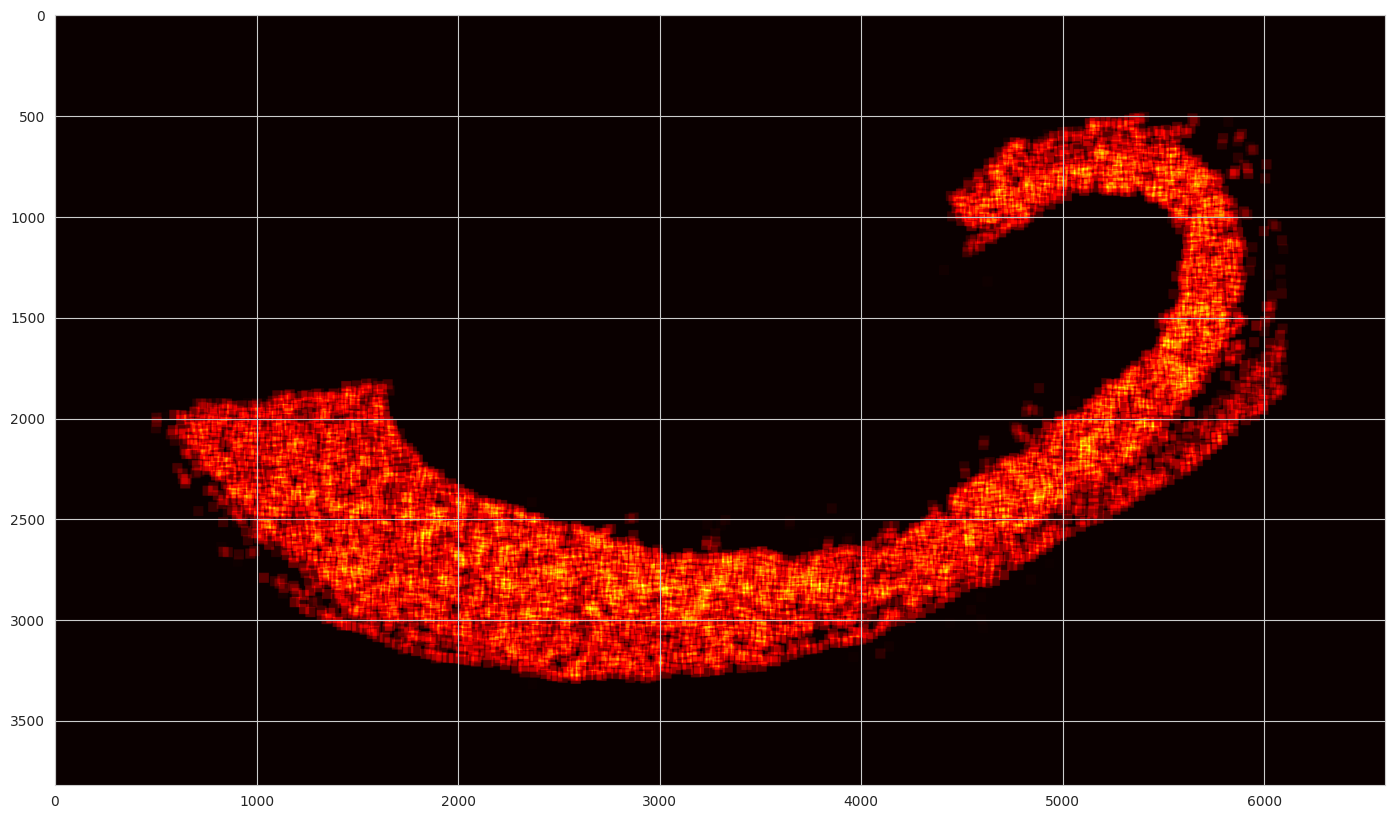

In [177]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.imshow(sparsed_vertex_degree_matrix, cmap='hot')
plt.show()

In [188]:
clusters = list(networkx.community.louvain_communities(random_cells_graph))

In [191]:
vertex_colors = {}
for color, cluster in enumerate(clusters):
    for vert_index in cluster:
        vertex_colors[vert_index] = color

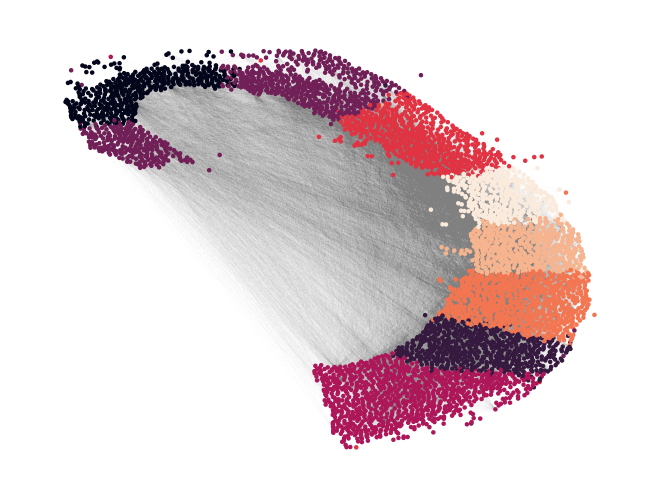

In [199]:
networkx.draw(
    random_cells_graph, 
    node_size=5, 
    pos=poses, 
    node_color=[vertex_colors[i] for i in random_cells_graph.nodes], 
    edge_color="#808080", 
    width=.0001,
)

In [ ]:
# clustering but for graph based on genes

In [20]:
dist_importance = 0.5
edge_probability_genes_important = 1 / 2 * (
    dist_importance * array_of_all_distance_probs + 
    (2 - dist_importance) * array_of_all_gene_exp_probs
)

In [21]:
gene_important_random_cells_graph = networkx.Graph()
for i in tqdm.tqdm(range(total_cell_amount)):
    for j in range(i + 1, total_cell_amount):
        if numpy.random.random() < edge_probability_genes_important[i][j]:
            gene_important_random_cells_graph.add_edge(i, j)

  0%|          | 0/4872 [00:00<?, ?it/s]

In [23]:
poses = {idx: (cells[cell_id].x, cells[cell_id].y) for idx, cell_id in enumerate(all_cell_ids)}

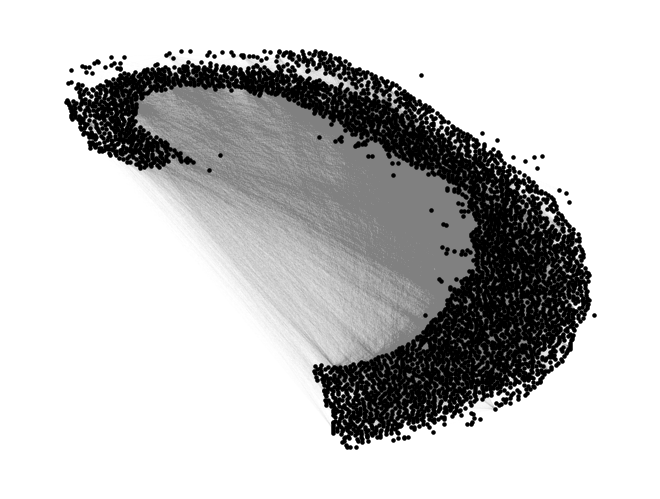

In [24]:
networkx.draw(
    gene_important_random_cells_graph, 
    node_size=5, 
    node_color="black", 
    pos=poses, 
    edge_color="#808080", 
    width=.0001
)

In [25]:
gene_based_clusters = list(networkx.community.louvain_communities(gene_important_random_cells_graph))
vertex_colors_based_on_genes = {}
for color, cluster in enumerate(gene_based_clusters):
    for vert_index in cluster:
        vertex_colors_based_on_genes[vert_index] = color

In [26]:
len(gene_based_clusters)

8

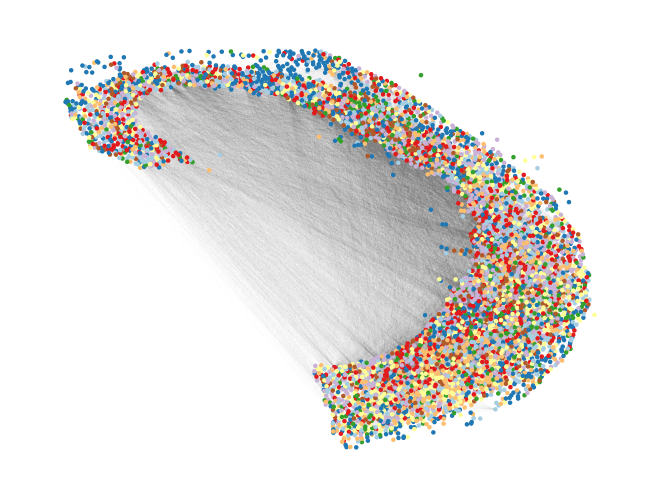

In [48]:
networkx.draw(
    gene_important_random_cells_graph, 
    node_size=5, 
    pos=poses, 
    node_color=[vertex_colors_based_on_genes[i] for i in gene_important_random_cells_graph.nodes], 
    edge_color="#808080", 
    width=.00005,
    cmap=matplotlib.colormaps["Paired"]
)

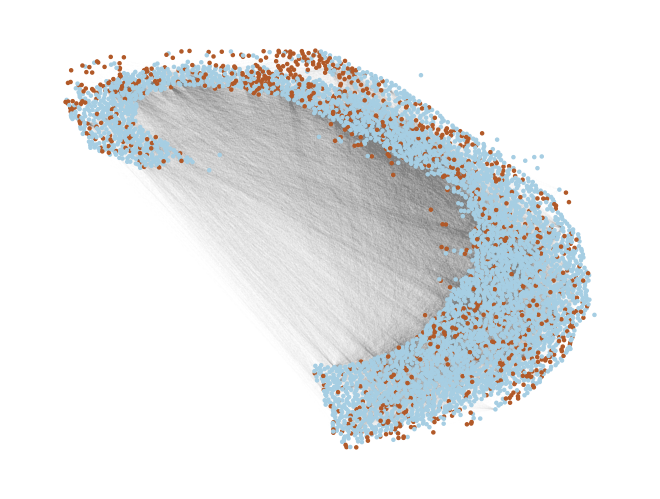

In [39]:
networkx.draw(
    gene_important_random_cells_graph, 
    node_size=5, 
    pos=poses, 
    node_color=[vertex_colors_based_on_genes[i] == 1 for i in gene_important_random_cells_graph.nodes], 
    edge_color="#808080", 
    width=.00005,
    cmap=matplotlib.colormaps["Paired"]
)

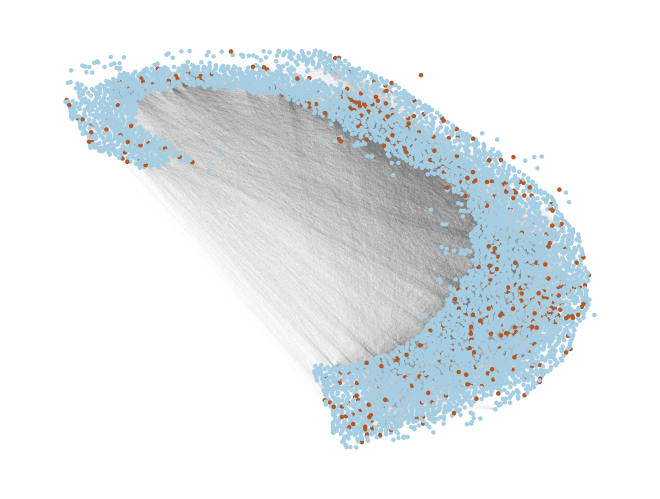

In [40]:
networkx.draw(
    gene_important_random_cells_graph, 
    node_size=5, 
    pos=poses, 
    node_color=[vertex_colors_based_on_genes[i] == 2 for i in gene_important_random_cells_graph.nodes], 
    edge_color="#808080", 
    width=.00005,
    cmap=matplotlib.colormaps["Paired"]
)

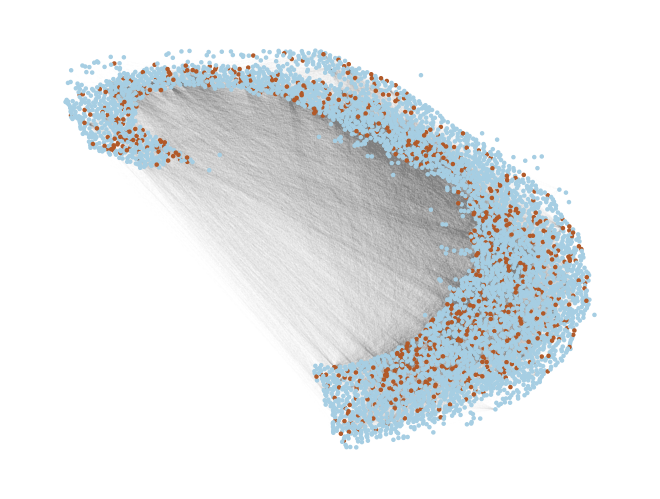

In [43]:
networkx.draw(
    gene_important_random_cells_graph, 
    node_size=5, 
    pos=poses, 
    node_color=[vertex_colors_based_on_genes[i] == 3 for i in gene_important_random_cells_graph.nodes], 
    edge_color="#808080", 
    width=.00005,
    cmap=matplotlib.colormaps["Paired"]
)

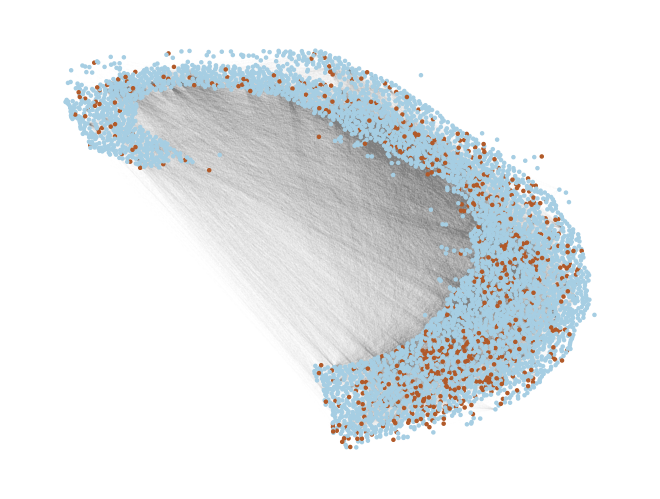

In [44]:
networkx.draw(
    gene_important_random_cells_graph, 
    node_size=5, 
    pos=poses, 
    node_color=[vertex_colors_based_on_genes[i] == 4 for i in gene_important_random_cells_graph.nodes], 
    edge_color="#808080", 
    width=.00005,
    cmap=matplotlib.colormaps["Paired"]
)

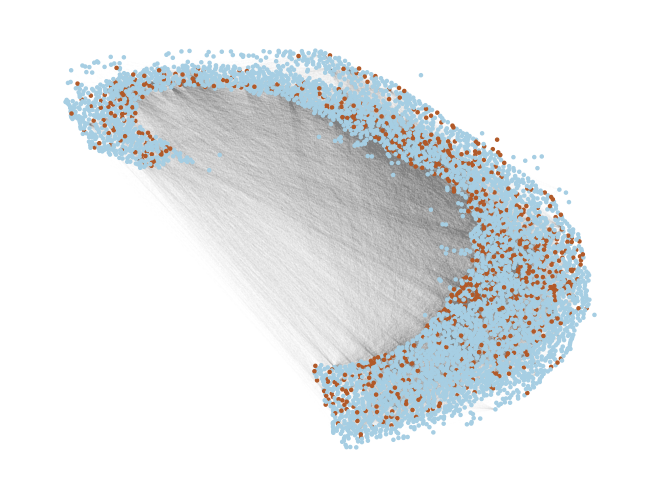

In [46]:
networkx.draw(
    gene_important_random_cells_graph, 
    node_size=5, 
    pos=poses, 
    node_color=[vertex_colors_based_on_genes[i] == 5 for i in gene_important_random_cells_graph.nodes], 
    edge_color="#808080", 
    width=.00005,
    cmap=matplotlib.colormaps["Paired"]
)

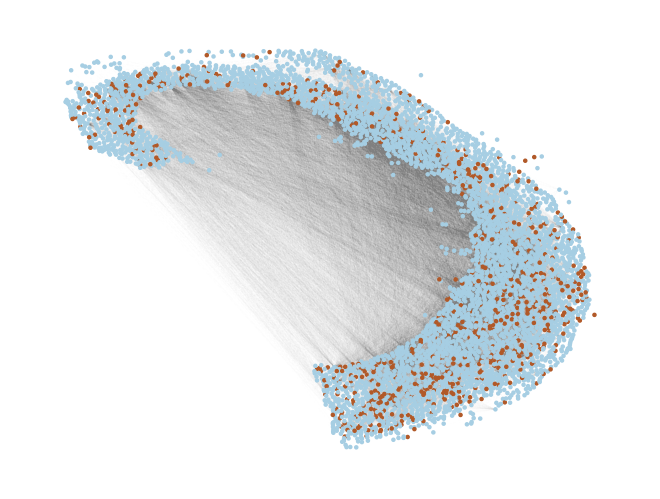

In [47]:
networkx.draw(
    gene_important_random_cells_graph, 
    node_size=5, 
    pos=poses, 
    node_color=[vertex_colors_based_on_genes[i] == 6 for i in gene_important_random_cells_graph.nodes], 
    edge_color="#808080", 
    width=.00005,
    cmap=matplotlib.colormaps["Paired"]
)

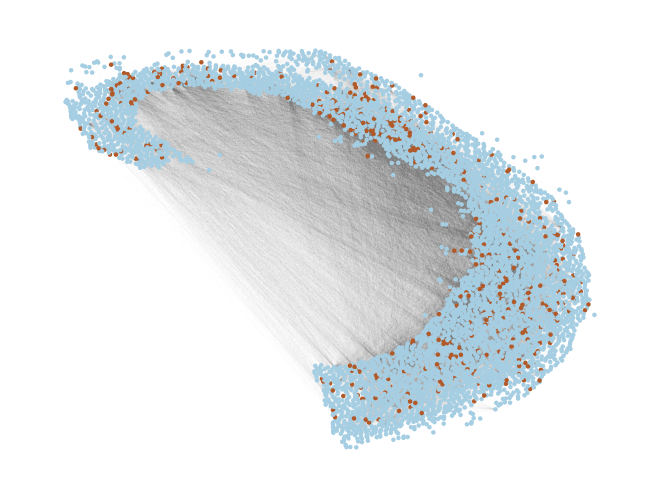

In [49]:
networkx.draw(
    gene_important_random_cells_graph, 
    node_size=5, 
    pos=poses, 
    node_color=[vertex_colors_based_on_genes[i] == 7 for i in gene_important_random_cells_graph.nodes], 
    edge_color="#808080", 
    width=.00005,
    cmap=matplotlib.colormaps["Paired"]
)

In [51]:
# weighted not-random graph

In [342]:
threshold_dist = 1
threshold_gene = 0.12
weighted_cells_graph = networkx.Graph()
for i in tqdm.tqdm(range(total_cell_amount)):
    for j in range(i + 1, total_cell_amount):
        if array_of_all_gene_exp_probs[i][j] > 1.5 * threshold_gene and array_of_all_distance_probs[i][j] < threshold_dist / 10000:
            weighted_cells_graph.add_edge(
                i, 
                j, 
                weight=50 * array_of_all_gene_exp_probs[i][j]
            )


  0%|          | 0/4872 [00:00<?, ?it/s]

In [343]:
len(weighted_cells_graph.edges)

8180

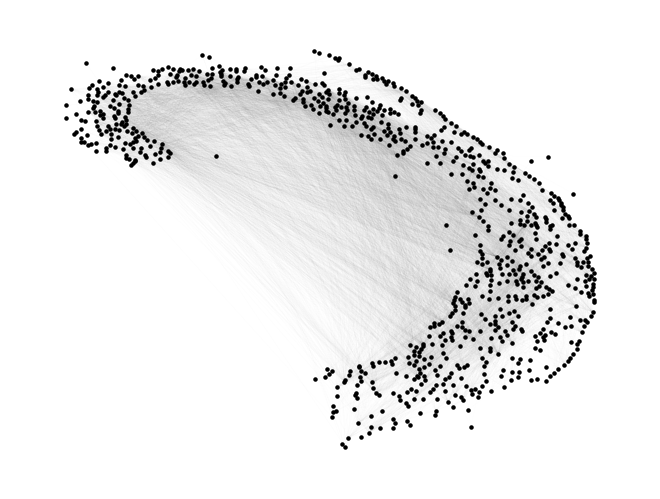

In [345]:
networkx.draw(
    weighted_cells_graph, 
    node_size=5, 
    pos=poses, 
    edge_color="#808080", 
    width=.005,
    node_color="black",
)

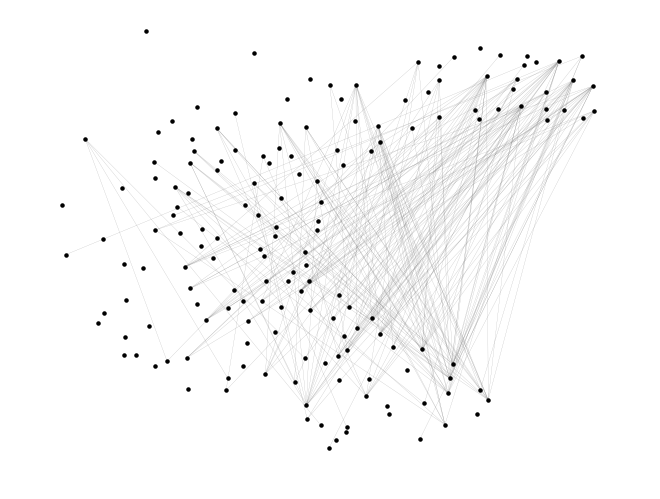

In [347]:
networkx.draw(
    weighted_cells_graph.subgraph(vertex_subset), 
    node_size=5, 
    pos=poses, 
    edge_color="#808080", 
    width=.1,
    node_color="black",
)

In [354]:
components = list(networkx.connected_components(weighted_cells_graph))
len(components)

28

In [355]:
print(list(map(len, components)))

[822, 17, 2, 6, 2, 2, 2, 2, 2, 2, 2, 3, 3, 2, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


In [356]:
main_component = components[0]

In [357]:
filtered_weighted_graph = weighted_cells_graph.subgraph(main_component)

In [358]:
weights = [filtered_weighted_graph[u][v]['weight'] for u,v in filtered_weighted_graph.edges]

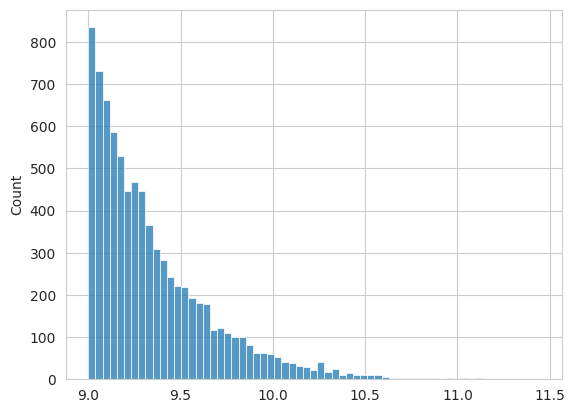

In [359]:
seaborn.histplot(weights)
plt.show()

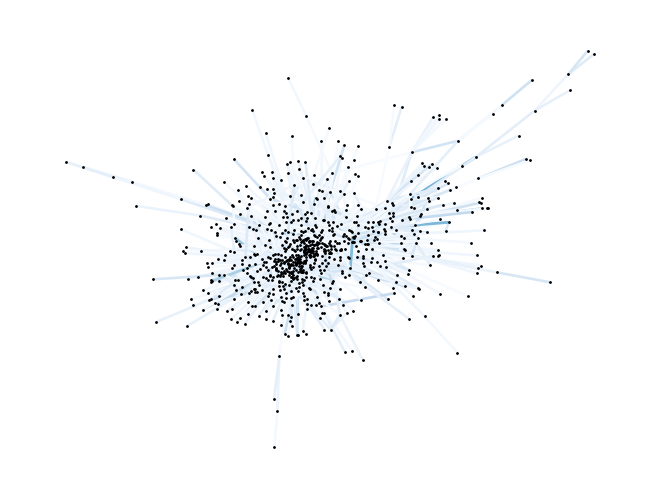

In [378]:
networkx.draw(
    filtered_weighted_graph, 
    node_size=1, 
    width=numpy.array(weights) / 5,
    node_color="black",
    edge_color=weights,
    edge_cmap = plt.cm.Blues,
)

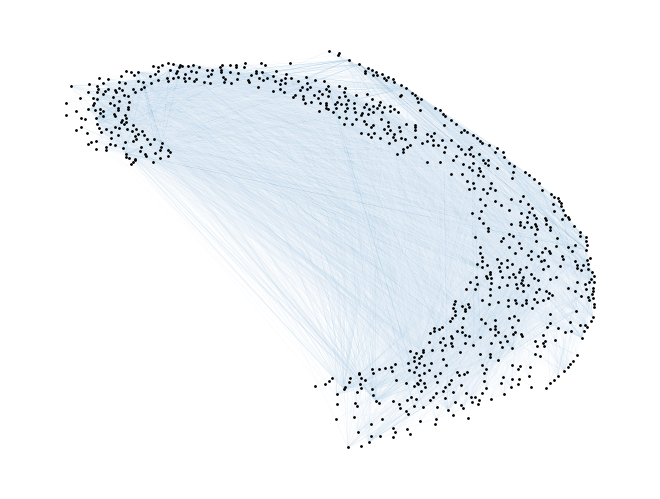

In [361]:
networkx.draw(
    filtered_weighted_graph, 
    node_size=1, 
    pos=poses, 
#     edge_color="#808080", 
    width=.09,
    node_color="black",
    edge_color=weights,
    edge_cmap = plt.cm.Blues,
)

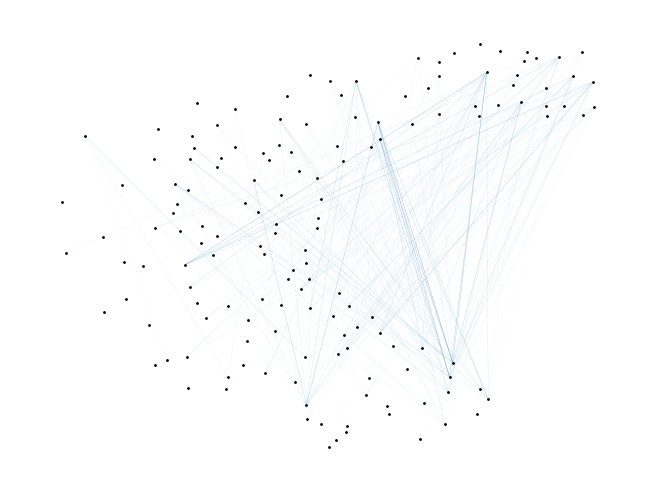

In [362]:
filtered_cells_subgraph = filtered_weighted_graph.subgraph(set(vertex_subset).intersection(set(main_component)))
networkx.draw(
    filtered_cells_subgraph, 
    node_size=1, 
    pos=poses, 
#     edge_color="#808080", 
    width=[filtered_cells_subgraph[u][v]['weight']/100 for u,v in filtered_cells_subgraph.edges],
    node_color="black",
    edge_color=numpy.log([filtered_cells_subgraph[u][v]['weight'] for u,v in filtered_cells_subgraph.edges]) / 10,
    edge_cmap = plt.cm.Blues,
)

In [367]:
# weights_based_clusters = list(
#     networkx.community.asyn_fluidc(
#         filtered_weighted_graph,
#         k = 11,
#     )
# )

weights_based_clusters = list(
    networkx.community.louvain_communities(
        filtered_weighted_graph,
        weight="weight"
    )
)


In [368]:
vertex_colors = dict()
for color, cluster in enumerate(weights_based_clusters):
    for node in cluster:
        vertex_colors[node] = color
vertex_colors = [vertex_colors[node] for node in filtered_weighted_graph.nodes]
len(set(vertex_colors))

12

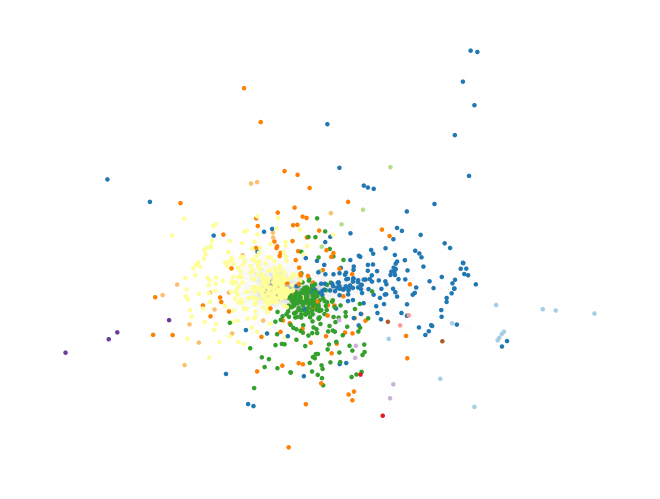

In [379]:
networkx.draw(
    filtered_weighted_graph, 
    node_size=5, 
    node_color=vertex_colors, 
    edge_color="#808080", 
    width=.005,
    cmap=matplotlib.colormaps["Paired"]
)

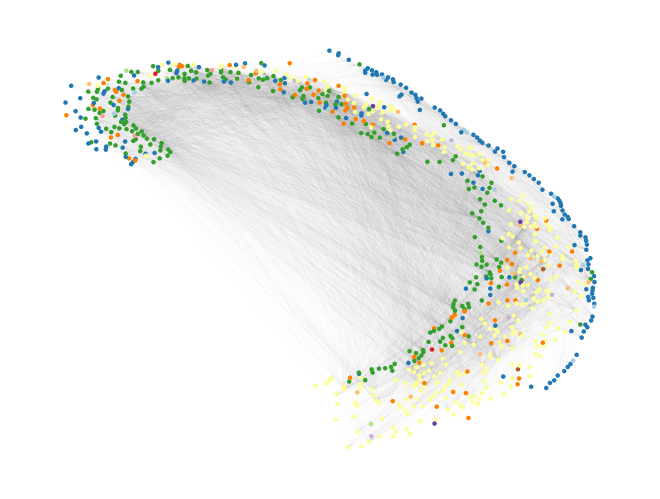

In [369]:
networkx.draw(
    filtered_weighted_graph, 
    node_size=5, 
    pos=poses, 
    node_color=vertex_colors, 
    edge_color="#808080", 
    width=.005,
    cmap=matplotlib.colormaps["Paired"]
)

1000